## 1. 프로젝트 개요

- 공유 오피스 3일 무료 체험 데이터를 활용하여 출입 및 방문 패턴을 분석하여 결제 전환 여부 예측 모델을 구축하고 모델을 기반으로
- 유저 행동 특성별 타겟 마케팅 전략을 수립한다.

### 1-1 활용 데이터셋 
- *본 프로젝트는 기업 내부 데이터를 기반으로 분석되었으며, 보안 및 기밀 유지를 위해 원본 데이터는 포함되어 있지 않습니다. 문제 발생 시 즉시 삭제*
- 공유 오피스 3일 무로 체험 데이터(2021.05.01~2023.12.31)
    - `3일 체험 신청자 출입 기록 로그`
    - `3일 체험 신청`
    - `3일 체험 신청자 일자별 방문 기록`
    - `3일 체험 신청자 결제 여부`
    - `지점별 면적`

### 1-2 EDA 인사이트 결과

- 3일 무료 체험의 유료 결제 전환율
    - 방문자 5707명 중 3478명(약 61%)이 무료 체험 방문 후 이탈하여 결제 전환율이 낮음
    - 무료 체험 방문자는 이용 목적이 뚜렷하지만 결제 전환까지 동기가 부족했음을 시사함 
- 결제 여부에 따른 방문 일수별 체류 시간 비교 
    - 방문 일수가 증가할수록 체류 시간 증가 
    - 하지만 모든 방문 구간에서 미결제 유저의 평균 체류 시간이 더 긴 경향 
    - 미결제 유저가 더 오래 머물렀다는 점은 만족도는 높지만 결제 유도 설계를 보완해야함을 시사
    - 결제 유저는 짧고 효율적으로 이용하는 경향이 있어 행동 패턴 중심 개선이 중요 
- 결제 유저의 방문 패턴
    - 입실 시각: 새벽~ 이른 아침(0~12시)에 집중, 새벽 4~5시가 피크 타임 
    - 퇴실 시각: 아침~ 오후(7~14시)까지 지속, 8~10시에 집중됨 
    - 주말 이용자 비중 낮음
    - 방문 일수가 늘어날수록 결제 전환율이 상승하는 경향
    - 결제자의 약 92%가 3일 중 1~2일 방문 후 결제 
    - 요일별 시간대별 맞춤 전략과 방문 반복 유도 및 2일차 결제 유도 설계과 중요

## 데이터 환경 설정 및 라이브러리 불러오기

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import koreanize_matplotlib

In [3]:
site_path = '/Users/SongKG/Downloads/중급 공유오피스 데이터 /site_area.csv'
access_path = '/Users/SongKG/Downloads/중급 공유오피스 데이터 /trial_access_log.csv'
payment_path = '/Users/SongKG/Downloads/중급 공유오피스 데이터 /trial_payment.csv'
register_path = '/Users/SongKG/Downloads/중급 공유오피스 데이터 /trial_register.csv'
visit_path = '/Users/SongKG/Downloads/중급 공유오피스 데이터 /trial_visit_info.csv'

site_df1 = pd.read_csv(site_path)
access_log_df1 = pd.read_csv(access_path)
payment_df1 = pd.read_csv(payment_path)
register_df1 = pd.read_csv(register_path)
visit_df1 = pd.read_csv(visit_path)

site_df = site_df1.copy()
access_log_df = access_log_df1.copy()
payment_df = payment_df1.copy()
register_df = register_df1.copy()
visit_df = visit_df1.copy()

In [4]:
access_log_df = access_log_df.sort_values(by=['user_uuid', 'cdate']).reset_index(drop=True)

## 2. 데이터 전처리

- 입실 혹은 퇴실 로그만 있는 유저 제거
- 유저별 방문 날짜별 입실(1) -> 퇴실(2) 로그 쌍을 가진 유저만 정상 방문으로 간주 
- 유저별 퇴실 로그가 퇴실이거나 마지막 로그가 입실인 로그 시스템 오류로 판단하여 제거
- 중복되는 로그(입실 -> 입실, 퇴실 -> 퇴실) 중 첫 행만 남기고 제거 
- 방문자 6026명 중 5707명의 출입 기록 로그 데이터로 진행

In [11]:
### 출입 기록 로그 
access_log_df['user_uuid'].nunique()

6026

### checkin 값이 하나만 존재하는 유저 
- checkin 기록이 입실만 있거나 퇴실만 존재하는 유저 : 40명
- 비정상 체크인 후보

In [5]:
abnormal_users = access_log_df.groupby('user_uuid')['checkin'].nunique()
abnormal_users = abnormal_users[abnormal_users < 2].index  
len(abnormal_users)

40

In [6]:
abnormal_logs = access_log_df[access_log_df['user_uuid'].isin(abnormal_users)]

In [7]:
# 입실만 있거나 퇴실만 있는 유저 제외
checkin_count= access_log_df.groupby('user_uuid')['checkin'].nunique()
valid_users = checkin_count[checkin_count == 2].index  
access_log_df2 = access_log_df[access_log_df['user_uuid'].isin(valid_users)]

In [8]:
print(access_log_df2.shape)

(63664, 5)


In [9]:
# 유저별 checkin 시퀀스
user_checkin_seqs = access_log_df2.sort_values(['user_uuid', 'cdate']) \
                                   .groupby('user_uuid')['checkin'].apply(list)
user_checkin_seqs

user_uuid
000590dc-046f-462b-8225-4c81a97b7166                                   [1, 2, 1, 2, 1, 2]
000be14f-ba0f-4af6-bc2c-7b00dfcbc98c    [1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, ...
0018e22d-a2cc-4e06-bca2-d6a041770f3b    [1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, ...
002606d9-38ca-48f3-910c-cbfada9a9109                             [1, 2, 1, 2, 1, 2, 1, 2]
002a7570-90dd-4cab-b0aa-b0e40f7ef27a                       [1, 2, 1, 2, 1, 2, 1, 2, 1, 2]
                                                              ...                        
ffc79669-ed11-4cde-86d4-8ec232ac7b14                          [1, 2, 1, 2, 1, 2, 1, 2, 1]
ffcb7950-d150-40ae-a6bf-f85f5c2b9702                       [1, 2, 1, 2, 1, 2, 1, 2, 1, 2]
ffce32ca-2efc-4485-b685-4b65811c2dcf                                         [1, 2, 1, 2]
ffd287bc-2797-4788-82fa-6268c82e7fa9    [1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, ...
fffbf2b3-7853-4c07-bd2a-aae686ac9013                                [1, 1, 2, 1, 2, 1, 2]


### checkin 정상 유저만 추출

In [10]:
access_log_df2['cdate'] = pd.to_datetime(access_log_df2['cdate'])

/var/folders/kg/chgs_d9545562m_vjpsykkdc0000gp/T/ipykernel_98272/635444691.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  access_log_df2['cdate'] = pd.to_datetime(access_log_df2['cdate'])


In [11]:
# 유저별 + 날짜별로 checkin 시퀀스를 수집
checkin_sequences = (
    access_log_df2
    .sort_values(['user_uuid', 'cdate'])
    .groupby(['user_uuid', access_log_df2['cdate'].dt.date])['checkin']
    .apply(list)
)

In [12]:
def has_enter_then_exit(seq): # checkin 리스트가 seq
    for i in range(len(seq) - 1):
        # 쌍으로 비교 
        if seq[i] == 1 and seq[i + 1] == 2:
            return True
    return False

valid_days = checkin_sequences.apply(has_enter_then_exit)
valid_days

user_uuid                             cdate     
000590dc-046f-462b-8225-4c81a97b7166  2023-09-05    True
000be14f-ba0f-4af6-bc2c-7b00dfcbc98c  2021-09-30    True
                                      2021-10-01    True
0018e22d-a2cc-4e06-bca2-d6a041770f3b  2023-11-15    True
                                      2023-11-16    True
                                                    ... 
ffce32ca-2efc-4485-b685-4b65811c2dcf  2023-11-01    True
                                      2023-11-02    True
ffd287bc-2797-4788-82fa-6268c82e7fa9  2023-04-07    True
                                      2023-04-08    True
fffbf2b3-7853-4c07-bd2a-aae686ac9013  2022-01-13    True
Name: checkin, Length: 9181, dtype: bool

In [13]:
# 2. 유저별로 모든 날짜가 정상인지 확인
valid_users = valid_days.groupby('user_uuid').all()

# 3. 정상 유저 ID만 추출
valid_user_ids = valid_users[valid_users].index

In [14]:
# 4. 원본 로그에서 정상 유저만 필터링
clean_access_log = access_log_df2[access_log_df2['user_uuid'].isin(valid_user_ids)]

In [15]:
print(clean_access_log.shape) 
print(clean_access_log['user_uuid'].nunique())

(60472, 5)
5709


In [16]:
# 1. 유저 집합 구하기
users_in_visit = set(visit_df['user_uuid'].dropna().unique())

# 2. 공통 유저만 필터링
cleaned_logs = clean_access_log[clean_access_log['user_uuid'].isin(users_in_visit)].copy()

In [17]:
cleaned_logs.shape

(60444, 5)

In [18]:
def drop_edge_if_invalid(df):
    df = df.sort_values(by='cdate')
    
    # 첫 퇴실이면 제거
    if df['checkin'].iloc[0] == 2:
        df = df.iloc[1:]
    
    # 마지막 입실이면 제거
    if len(df) > 0 and df['checkin'].iloc[-1] == 1:
        df = df.iloc[:-1]
    
    return df

# 유저별로 적용
cleaned_logs_trimmed = cleaned_logs.groupby('user_uuid', group_keys=False).apply(drop_edge_if_invalid).reset_index(drop=True)
cleaned_logs_trimmed.shape


/var/folders/kg/chgs_d9545562m_vjpsykkdc0000gp/T/ipykernel_98272/4240159947.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cleaned_logs_trimmed = cleaned_logs.groupby('user_uuid', group_keys=False).apply(drop_edge_if_invalid).reset_index(drop=True)


(60126, 5)

In [19]:
def remove_redundant_checkins(df):  # ← 이렇게 함수 이름 바꿔줘
    df = df.sort_values(by='cdate')
    return df[df['checkin'] != df['checkin'].shift(1)]

# 그 후 변수명 사용 가능
final_logs = cleaned_logs_trimmed.groupby('user_uuid', group_keys=False).apply(
    remove_redundant_checkins
).reset_index(drop=True)

/var/folders/kg/chgs_d9545562m_vjpsykkdc0000gp/T/ipykernel_98272/1920760519.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_logs = cleaned_logs_trimmed.groupby('user_uuid', group_keys=False).apply(


In [20]:
payment_unique_df = payment_df.drop_duplicates(subset='user_uuid')

In [21]:
final_logs = final_logs.merge(payment_unique_df, on='user_uuid')

In [22]:
final_logs = final_logs.merge(site_df, on='site_id')

In [24]:
final_logs['date'] = pd.to_datetime(final_logs['cdate']).dt.date

In [25]:
# 1. visit_days: 유저별로 고유한 cdate 수
visit_days = final_logs.groupby('user_uuid')['date'].nunique().rename('visit_days')

# 2. session_count: 유저별로 입실(1) 로그 개수
session_count = final_logs[final_logs['checkin'] == 1].groupby('user_uuid').size().rename('session_count')

# 3. 병합해서 user_df 만들기
user_df = pd.concat([visit_days, session_count], axis=1).fillna(0).reset_index()

# 4. session_count를 정수형으로 변환
user_df['session_count'] = user_df['session_count'].astype(int)

# 확인
user_df.head()

,user_uuid,visit_days,session_count
0,000590dc-046f-462b-8225-4c81a97b7166,1,3
1,000be14f-ba0f-4af6-bc2c-7b00dfcbc98c,2,9
2,0018e22d-a2cc-4e06-bca2-d6a041770f3b,2,8
3,002606d9-38ca-48f3-910c-cbfada9a9109,2,4
4,002a7570-90dd-4cab-b0aa-b0e40f7ef27a,1,5


In [26]:
user_df = user_df.merge(payment_unique_df, on='user_uuid')

In [27]:
# 1. 유저별 평균/총 체류 시간 집계
stay_time_stats = visit_df.groupby('user_uuid')['stay_time_second'].agg(
    avg_stay_time='mean',
    total_stay_time='sum'
).reset_index()

# 2. 기존 user_df와 병합
user_df = user_df.merge(stay_time_stats, on='user_uuid', how='left')

In [29]:
# 1. 유저별 고유 지점 수 계산
visit_sites = final_logs.groupby('user_uuid')['site_id'].nunique().rename('visit_sites_count').reset_index()

# 2. user_df에 병합
user_df = user_df.merge(visit_sites, on='user_uuid', how='left')

# 3. 방문 지점이 없었던 유저는 0으로 채움
user_df['visit_sites_count'] = user_df['visit_sites_count'].fillna(0).astype(int)

# 결과 확인
user_df['visit_sites_count'].value_counts()

visit_sites_count
1    5499
2     186
3      21
4       1
Name: count, dtype: int64

## 3. EDA

### 3-1 방문횟수별 유료 결제 전환율

In [30]:
user_visit_count = visit_df.groupby('user_uuid')['date'].nunique().reset_index(name='visit_days')

# 방문 일수별 유저 수 
user_visit_count['visit_days'].value_counts()

visit_days
1    3220
2    1932
3    1297
4      85
Name: count, dtype: int64

In [127]:
user_visit_count[user_visit_count['visit_days'] > 3]

,user_uuid,visit_days
51,01dab720-a416-4444-94bc-dee7fdbe8bd2,4
141,051c2bb0-dcdf-494d-b10c-d72f2c23fccb,4
146,0563c265-e2e2-4bc9-ba7d-70dfeee006ee,4
225,07d073f3-d749-4a78-bc20-099d23ba93b3,4
232,08159317-8a5c-4774-a8d8-97dac9146f86,4
...,...,...
6029,eb7cf947-5c73-4b54-8511-16315ec53a02,4
6065,edbdc71b-5f82-4a5e-aafc-08d0a1c1b9c6,4
6205,f2838847-e7f5-4719-8818-5d39256d122e,4
6302,f655be50-4b26-46cb-823b-bcc01108b3cc,4


In [128]:
# 결제 여부가 있는 유저 정보
user_payment = payment_df[['user_uuid', 'is_payment']].drop_duplicates()
user_payment

,user_uuid,is_payment
0,2b251333-8676-4c11-a736-dcf2350f8821,0
1,e111619a-0975-451b-9a4a-bc8aea7b7b84,0
2,4a184795-b056-4572-a874-644f68609ea3,1
3,2ba8ab19-2d40-4423-ad04-f0f9ca814871,0
4,1d49ba36-6c23-405b-9514-aa7f4aeceff0,0
...,...,...
9654,d7599df4-1e5a-4f5e-97ce-c42047bfd87c,0
9655,43263092-3b28-4817-9fa9-4205ad3097fe,0
9656,51a40f33-1027-4544-9b95-45bca7c104fb,0
9657,3e649531-bf5b-4b99-84e5-ca3e0e647d0c,0


In [129]:
visit_payment_users = user_visit_count.merge(user_payment, on='user_uuid', how='left')
visit_payment_users

,user_uuid,visit_days,is_payment
0,000590dc-046f-462b-8225-4c81a97b7166,1,0
1,000be14f-ba0f-4af6-bc2c-7b00dfcbc98c,3,1
2,0018e22d-a2cc-4e06-bca2-d6a041770f3b,2,0
3,002606d9-38ca-48f3-910c-cbfada9a9109,2,0
4,002a7570-90dd-4cab-b0aa-b0e40f7ef27a,2,1
...,...,...,...
6529,ffc79669-ed11-4cde-86d4-8ec232ac7b14,2,0
6530,ffcb7950-d150-40ae-a6bf-f85f5c2b9702,2,0
6531,ffce32ca-2efc-4485-b685-4b65811c2dcf,1,0
6532,ffd287bc-2797-4788-82fa-6268c82e7fa9,3,0


In [174]:
result = (
    visit_payment_users
    .groupby(['visit_days', 'is_payment'])['user_uuid']
    .nunique()
    .reset_index(name='user_count')
    .pivot(index='visit_days', columns='is_payment', values='user_count')
    .fillna(0)
    .rename(columns={0: '무료', 1: '유료'})
    .astype(int)
    .sort_index()
)
result

is_payment,무료,유료
visit_days,,
1,2144,1076
2,1121,811
3,690,607
4,15,70


In [175]:
result['전환율'] = round(result['유료'] / (result['유료'] + result['무료']),3)
result

is_payment,무료,유료,전환율
visit_days,,,
1,2144,1076,0.334
2,1121,811,0.420
3,690,607,0.468
4,15,70,0.824


#### 출입 기록 데이터 전처리 
 1. 출입 기록(access_log) 데이터 유저별 날짜순 오름차순 정렬
 2. 유저별 날짜별 첫 행이 퇴실인 행이거나 마지막 행이 퇴실인 행 제거
 3. 연속된 checkin 값 중 첫 행만 남기고 제거하기

- 전처리 후 출입기록 정상 체크인 유저 5707명 유지가 목표 
- 전처리 후 데이터 행 수
    - 60124개 -> 57370개(2744개 제거)

In [31]:
# 1. 유저별 입실 횟수(=세션 수)
session_counts = final_logs[final_logs['checkin'] == 1] \
    .groupby('user_uuid')['checkin'] \
    .count() \
    .rename('session_count')
session_counts

user_uuid
000590dc-046f-462b-8225-4c81a97b7166     3
000be14f-ba0f-4af6-bc2c-7b00dfcbc98c     9
0018e22d-a2cc-4e06-bca2-d6a041770f3b     8
002606d9-38ca-48f3-910c-cbfada9a9109     4
002a7570-90dd-4cab-b0aa-b0e40f7ef27a     5
                                        ..
ffc79669-ed11-4cde-86d4-8ec232ac7b14     4
ffcb7950-d150-40ae-a6bf-f85f5c2b9702     5
ffce32ca-2efc-4485-b685-4b65811c2dcf     2
ffd287bc-2797-4788-82fa-6268c82e7fa9    10
fffbf2b3-7853-4c07-bd2a-aae686ac9013     3
Name: session_count, Length: 5707, dtype: int64

- 3일 체험 방문자의 유료 결제 여부 
    - 3일 체험 신청자: 9624명
    - 전체: 5707명 
    - 무료(0): 3478명 (60.9%)
    - 유료(1): 2229명 (39.1%)

### 3-2 유저별 첫 방문 기록, 첫 방문 시간대
- 첫 방문 시간대 -> 아침/오후/저녁/심야

In [33]:
# 유저별 첫 방문 시각
first_visit = final_logs.groupby('user_uuid')['cdate'].min().reset_index()
first_visit.columns = ['user_uuid','first_visit_time'] 

first_visit['first_visit_hour'] = first_visit['first_visit_time'].dt.hour
first_visit['first_visit_month'] = first_visit['first_visit_time'].dt.to_period('M').astype(str)

first_visit.head()

,user_uuid,first_visit_time,first_visit_hour,first_visit_month
0,000590dc-046f-462b-8225-4c81a97b7166,2023-09-05 02:57:01.695334,2,2023-09
1,000be14f-ba0f-4af6-bc2c-7b00dfcbc98c,2021-09-30 07:31:14.861813,7,2021-09
2,0018e22d-a2cc-4e06-bca2-d6a041770f3b,2023-11-15 00:44:08.498847,0,2023-11
3,002606d9-38ca-48f3-910c-cbfada9a9109,2023-01-07 08:25:54.781175,8,2023-01
4,002a7570-90dd-4cab-b0aa-b0e40f7ef27a,2021-09-08 07:37:24.456986,7,2021-09


In [34]:
# 시간대 라벨링 함수
def assign_time_band(hour):
    if 6 <= hour < 12:
        return '아침'
    elif 12 <= hour < 18:
        return '오후'
    elif 18 <= hour < 24:
        return '저녁'
    else:
        return '심야'

# 시간대 컬럼 생성
first_visit['first_visit_time_band'] = first_visit['first_visit_hour'].apply(assign_time_band)

In [35]:
first_visit['first_visit_time_band'].value_counts()

first_visit_time_band
심야    3385
아침    1937
오후     272
저녁     113
Name: count, dtype: int64

In [36]:
final_logs = final_logs.merge(
    first_visit[['user_uuid', 'first_visit_time_band']],
    on='user_uuid',
    how='left'
)

EDA 기반 모델링 파생변수 후보군 생성

- `first_visit_time_band` : 첫 방문 시간대
- `first_visit_month` : 첫 방문 월
- `days_to_payment` : 결제까지 걸린 일수
- `total_stay_time` : 총 체류 시간 
- `avg_stay_time` : 평균 체류 시간 
- `visit_days` : 방문 일수 
- `visited_sites_count` : 방문 지점 개수(여러 지점 방문할수록 유료 결제 전환율이 올라가는가?)
- `session_count` : 입실 횟수(출입 빈도 보기 위함)
- `area_pyeong` : 첫 방문 지점 면적 

In [ ]:
# user_df = user_df.drop(columns=['visit_sites_count_x','visit_sites_count_y'])

### 3-3 방문패턴 분석
- 방문 일수가 늘어날수록 유저 수는 줄어들지만 전환율은 늘어나는 경향을 보임 

In [204]:
# 방문일수별 유저 수 및 전환율 집계
visit_days_summary = user_df.groupby('visit_days').agg(
    user_count=('user_uuid', 'count'),
    conversion_rate=('is_payment', 'mean')
).reset_index()

# 전환율을 퍼센트로 표현
visit_days_summary['conversion_rate'] *= 100
visit_days_summary.head(10)

,visit_days,user_count,conversion_rate
0,1,3293,35.894321
1,2,2026,42.991115
2,3,388,45.360825


In [ ]:
# 출입 횟수별 유저 수 및 결제 전환율 집계
session_summary = user_df.groupby('session_count').agg(
    user_count=('user_uuid', 'count'),
    conversion_rate=('is_payment', 'mean')
).reset_index()

# 전환율을 백분율로 변환
session_summary['conversion_rate'] *= 100
session_summary.head(20)

,session_count,user_count,conversion_rate
0,1,1014,39.349112
1,2,960,40.520833
2,3,789,35.741445
3,4,606,40.264026
4,5,492,38.821138
5,6,390,42.307692
6,7,296,39.189189
7,8,227,36.123348
8,9,186,36.021505
9,10,144,36.805556


#### 세션 카운트별 유료 결제자 수

In [ ]:
# session_count별 결제자 수만 집계
paid_by_session = (
    user_df[user_df['is_payment'] == 1]
    .groupby('session_count')['user_uuid']
    .count()
    .reset_index()
    .rename(columns={'user_uuid': 'paid_user_count'})
)

### 3-4 방문 지점 개수별 유료 결제 전환율 
- 대부분 유저가 1개 지점 방문, 전환율 보통 수준
- 2개 지점 비교 후 결제 가능성 높음 
- 소수 유저지만 전환율 나쁘지 않음

In [208]:
site_count_summary = user_df.groupby('visit_sites_count').agg(
    user_count=('user_uuid', 'count'),
    conversion_rate=('is_payment', 'mean')
).reset_index()

# 전환율 백분율 변환
site_count_summary['conversion_rate'] *= 100
site_count_summary

,visit_sites_count,user_count,conversion_rate
0,1,5499,38.861611
1,2,186,46.236559
2,3,21,28.571429
3,4,1,0.000000


### 3-5 첫 방문 월별 결제자 수
- 월별로는 대체적으로 결제율이 떨어지는 경향은 찾지 못함

In [ ]:
# 유저별 첫 방문일 추출 → 월 단위로 변환
first_visit_month = (
    final_logs.groupby('user_uuid')['cdate']
    .min()
    .dt.to_period('M')  # '2025-06' 형식
    .astype(str)
    .rename('first_visit_month'))

In [ ]:
access_log_final_df = final_logs.merge(first_visit_month, on='user_uuid', how='left')

In [ ]:
monthly_summary = user_df.groupby('first_visit_month').agg(
    user_count=('user_uuid', 'count'),
    paid_user_count=('is_payment', 'sum'),  # is_payment가 1이면 결제자
).reset_index()

# 전환율 계산 (%)
monthly_summary['conversion_rate'] = (monthly_summary['paid_user_count'] / monthly_summary['user_count']) * 100
monthly_summary.tail()

,first_visit_month,user_count,paid_user_count,conversion_rate
28,2023-09,208,63,30.288462
29,2023-10,183,55,30.054645
30,2023-11,190,40,21.052632
31,2023-12,244,54,22.131148
32,2024-01,2,0,0.000000


---

### 유료 결제 전환율 막대그래프 시각화

In [192]:
final_logs.groupby('is_payment')['user_uuid'].nunique()

is_payment
0    3478
1    2229
Name: user_uuid, dtype: int64

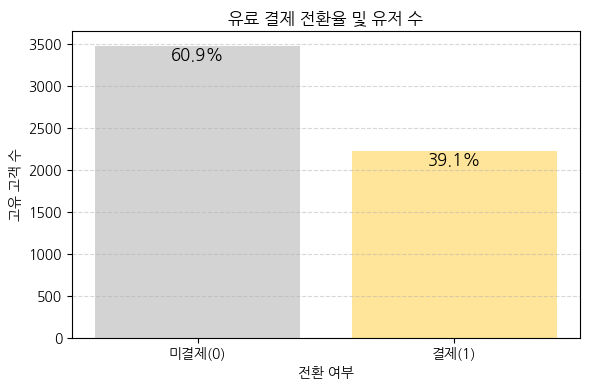

In [ ]:
import matplotlib.pyplot as plt

total_users = conversion_count.sum()
colors = ['lightgray', '#ffe599']

plt.figure(figsize=(6, 4))
bars = plt.bar(conversion_count.index, conversion_count.values, color=colors)

for bar, count in zip(bars, conversion_count.values):
    percentage = count / total_users * 100
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() - 10,  # 막대 상단에서 10만큼 내려서 내부에 고정 위치
        f'{percentage:.1f}%',
        ha='center', va='top', fontsize=12, color='black'
    )

plt.title('유료 결제 전환율 및 유저 수')
plt.ylabel('고유 고객 수')
plt.xlabel('전환 여부')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [195]:
# 3. user_uuid별 고유 방문일 수 계산
user_visit_days = final_logs.groupby('user_uuid')['date'].nunique().reset_index(name='visit_days')
# 4. 원본에 병합
final_logs = final_logs.merge(user_visit_days, on='user_uuid', how='left')

In [201]:
# visit_days가 3 초과인 경우 모두 3으로 통일
user_df['visit_days'] = user_df['visit_days'].apply(lambda x: min(x, 3))

In [202]:
user_df.groupby('visit_days')['user_uuid'].nunique()

visit_days
1    3293
2    2026
3     388
Name: user_uuid, dtype: int64

In [ ]:
access_log_final_df[access_log_final_df['is_payment'] == 1].groupby('visit_days')['user_uuid'].nunique()

visit_days
1    1182
2     871
3     176
Name: user_uuid, dtype: int64

In [ ]:
# 1. user_uuid별 방문일 수 집계 (앞서 만든 것)
user_visit_days = access_log_final_df.groupby('user_uuid')['date'].nunique().reset_index(name='visit_days')
user_visit_days['visit_days'] = user_visit_days['visit_days'].clip(upper=3)  

In [ ]:
# 2. user_uuid별 유료 결제 여부 (is_payment=1 여부만 유지)
user_payment = final_logs[['user_uuid', 'is_payment']].drop_duplicates('user_uuid')

,user_uuid,is_payment
0,000590dc-046f-462b-8225-4c81a97b7166,0
6,000be14f-ba0f-4af6-bc2c-7b00dfcbc98c,1
24,0018e22d-a2cc-4e06-bca2-d6a041770f3b,0
40,002606d9-38ca-48f3-910c-cbfada9a9109,0
48,002a7570-90dd-4cab-b0aa-b0e40f7ef27a,1
...,...,...
57322,ffc79669-ed11-4cde-86d4-8ec232ac7b14,0
57330,ffcb7950-d150-40ae-a6bf-f85f5c2b9702,0
57340,ffce32ca-2efc-4485-b685-4b65811c2dcf,0
57344,ffd287bc-2797-4788-82fa-6268c82e7fa9,0


In [197]:
user_summary = user_visit_days.merge(user_payment, on='user_uuid', how='left')

In [199]:
conversion_summary = user_df.groupby('visit_days').agg(
    total_users=('user_uuid', 'nunique'),
    payers=('is_payment', 'sum')  # is_payment가 1이면 결제자 수
).reset_index()

conversion_summary['conversion_rate'] = conversion_summary['payers'] / conversion_summary['total_users']
conversion_summary

,visit_days,total_users,payers,conversion_rate
0,1,3293,1182,0.358943
1,2,2026,871,0.429911
2,3,384,175,0.455729
3,4,4,1,0.250000


### 방문일 수에 따른 유료 결제 전환율 및 결제자 수 시각화

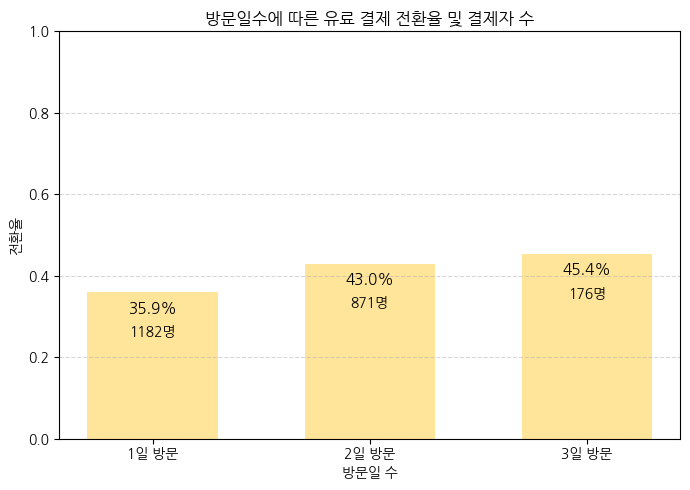

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))

# 막대: 전환율 기준으로 그리기
bars = plt.bar(
    conversion_summary['visit_days'],
    conversion_summary['conversion_rate'],
    color='#ffe599',
    width=0.6
)

# 텍스트: 막대 위에 전환율, 그 아래 결제자 수
for bar, rate, payer in zip(bars, conversion_summary['conversion_rate'], conversion_summary['payers']):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()

    # 전환율 텍스트 (막대 상단)
    plt.text(x, y - 0.02, f'{rate:.1%}', ha='center', va='top', fontsize=11, color='black')

    # 결제자 수 텍스트 (막대 내부 중간 아래)
    plt.text(x, y - 0.08, f'{payer}명', ha='center', va='top', fontsize=10, color='black')

plt.xticks(conversion_summary['visit_days'], [f'{d}일 방문' for d in conversion_summary['visit_days']])
plt.ylim(0, 1)
plt.title('방문일수에 따른 유료 결제 전환율 및 결제자 수')
plt.xlabel('방문일 수')
plt.ylabel('전환율')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### 결제 여부에 따른 방문일수별 평균 체류 시간

- `인사이트`
    - 미결제 그룹은 오래 머무른다는 점은 관심도는 높지만 결제 유도 설계의 필요성을 시사함
    - 미결제 그룹은 결정을 미루는 경향 
    - 결제자는 오히려 빠른 판단형 -> 체류시간보다 행동 중심 결제 설계 필요

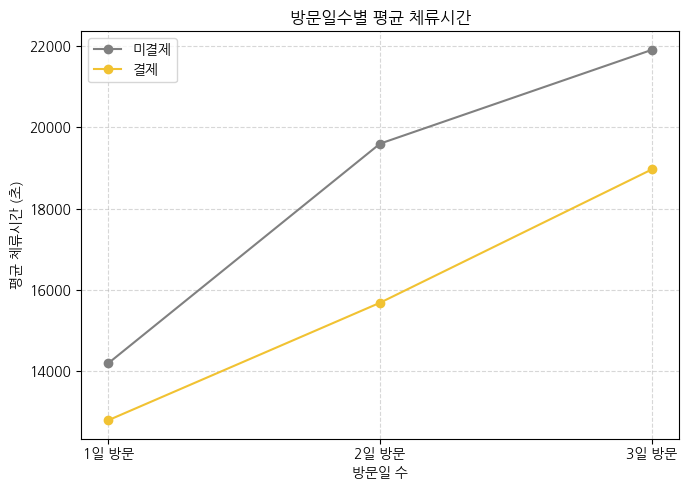

In [ ]:
pivot_df = stay_summary.pivot(index='visit_days', columns='is_payment', values='mean_stay_time')

x = pivot_df.index

# y축 값: 평균 체류시간
y_no_pay = pivot_df[0]  # 미결제 그룹
y_pay = pivot_df[1]     # 결제 그룹

# 2. 라인그래프 그리기
plt.figure(figsize=(7, 5))

# 미결제 라인
plt.plot(x, y_no_pay, marker='o', color='gray', label='미결제')

# 결제 라인
plt.plot(x, y_pay, marker='o', color='#f1c232', label='결제')  # 파스텔 노랑

# 3. 그래프 꾸미기
plt.title('방문일수별 평균 체류시간')
plt.xlabel('방문일 수')  # x축 라벨
plt.ylabel('평균 체류시간 (초)')  # y축 라벨
plt.xticks([1, 2, 3], ['1일 방문', '2일 방문', '3일 방문'])  # x축 표시
plt.grid(True, linestyle='--', alpha=0.5)  # 눈금선
plt.legend()  # 범례 표시

plt.tight_layout()
plt.show()

In [ ]:
area_summary = (
    user_area
    .groupby('area_pyeong')
    .agg(
        total_users=('user_uuid', 'nunique'),
        payers=('is_payment', 'sum')
    )
    .reset_index()
)

# 전환율 컬럼 추가
area_summary['conversion_rate'] = area_summary['payers'] / area_summary['total_users']

# 최종 요약 데이터프레임
area_summary

,area_pyeong,total_users,payers,conversion_rate
0,50,1591,604,0.379635
1,100,1417,541,0.381793
2,150,2872,1157,0.402855


- 지점 면적별 유료 결제 전환율은 표로 보여주기

In [ ]:
# 1. 유저별 방문 지점 수와 결제 여부만 추출하고 중복 제거
user_site_df = access_log_final_df[['user_uuid', 'visited_sites_count', 'is_payment']].drop_duplicates('user_uuid')

# 2. visited_sites_count를 기준으로 전체 유저 수, 유료 결제자 수 집계
site_summary = user_site_df.groupby('visited_sites_count').agg(
    total_users=('user_uuid', 'nunique'),
    payers=('is_payment', 'sum')
).reset_index()

# 3. 전환율 계산: 유료 결제자 수 ÷ 전체 유저 수
site_summary['conversion_rate'] = site_summary['payers'] / site_summary['total_users']

In [ ]:
site_summary

,visited_sites_count,total_users,payers,conversion_rate
0,1,5428,2095,0.385962
1,2,238,118,0.495798
2,3,39,16,0.410256
3,4,2,0,0.000000


In [ ]:
paid_df = access_log_final_df[access_log_final_df['is_payment'] == 1]
# timestamp가 datetime 형태라면 정렬 후 첫 방문만 추출
first_visit_df = paid_df.sort_values('cdate').drop_duplicates('user_uuid', keep='first')

In [ ]:
weekday_summary = first_visit_df['weekday'].value_counts().reset_index()
weekday_summary.columns = ['weekday', 'paid_user_count']
weekday_summary = weekday_summary.sort_values('weekday')  # 월~일 정렬은 필요 시 커스텀 정렬
weekday_summary

,weekday,paid_user_count
3,Friday,342
4,Monday,244
5,Saturday,221
6,Sunday,177
2,Thursday,368
0,Tuesday,476
1,Wednesday,401


### 요일별 결제자 수 시각화

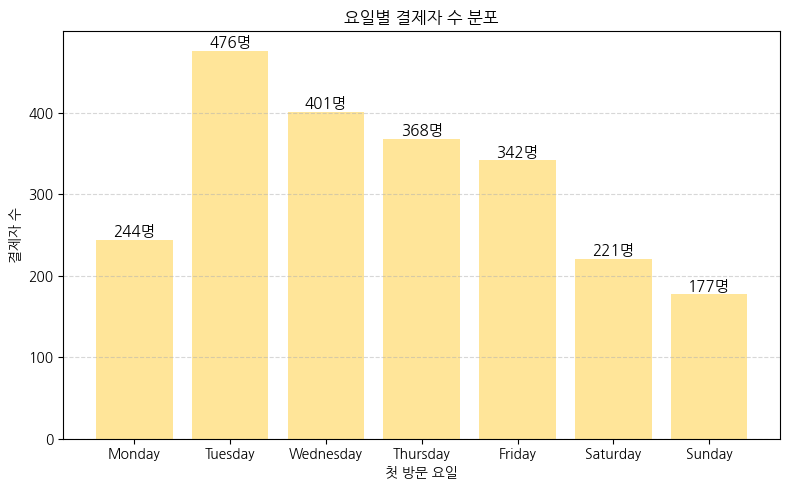

In [ ]:
# 요일 정렬 순서 지정 (월~일)
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# 요일 순서에 맞게 정렬
weekday_summary['weekday'] = pd.Categorical(weekday_summary['weekday'], categories=ordered_days, ordered=True)
weekday_summary = weekday_summary.sort_values('weekday')

# 시각화
plt.figure(figsize=(8, 5))
bars = plt.bar(
    weekday_summary['weekday'],
    weekday_summary['paid_user_count'],
    color='#ffe599'  # 파스텔 노랑
)

# 막대 위 텍스트 (중앙 위)
for bar in bars:
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    plt.text(x, y + 0.5, f'{int(y)}명', ha='center', va='bottom', fontsize=11)

plt.title('요일별 결제자 수 분포')
plt.xlabel('첫 방문 요일')
plt.ylabel('결제자 수')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
free_df = access_log_final_df[access_log_final_df['is_payment'] == 0]
# timestamp가 datetime 형태라면 정렬 후 첫 방문만 추출
first_visit_df2 = free_df.sort_values('cdate').drop_duplicates('user_uuid', keep='first')

In [ ]:
weekday_summary = first_visit_df2['weekday'].value_counts().reset_index()
weekday_summary.columns = ['weekday', 'free_user_count']
weekday_summary = weekday_summary.sort_values('weekday')  # 월~일 정렬은 필요 시 커스텀 정렬
weekday_summary

,weekday,free_user_count
2,Friday,515
5,Monday,411
4,Saturday,495
6,Sunday,283
3,Thursday,513
1,Tuesday,626
0,Wednesday,635


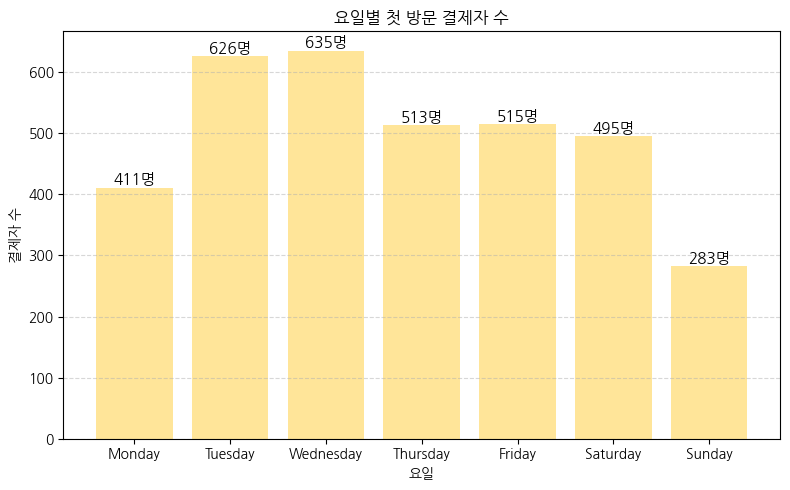

In [ ]:
# 요일 정렬 순서 지정 (월~일)
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# 요일 순서에 맞게 정렬
weekday_summary['weekday'] = pd.Categorical(weekday_summary['weekday'], categories=ordered_days, ordered=True)
weekday_summary = weekday_summary.sort_values('weekday')

# 시각화
plt.figure(figsize=(8, 5))
bars = plt.bar(
    weekday_summary['weekday'],
    weekday_summary['free_user_count'],
    color='#ffe599'  # 파스텔 노랑
)

# 막대 위 텍스트 (중앙 위)
for bar in bars:
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    plt.text(x, y + 0.5, f'{int(y)}명', ha='center', va='bottom', fontsize=11)

plt.title('요일별 첫 방문 결제자 수')
plt.xlabel('첫 방문 요일')
plt.ylabel('결제자 수')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 첫 방문 기준 결제 그룹의 입실 및 퇴실 시각 분포

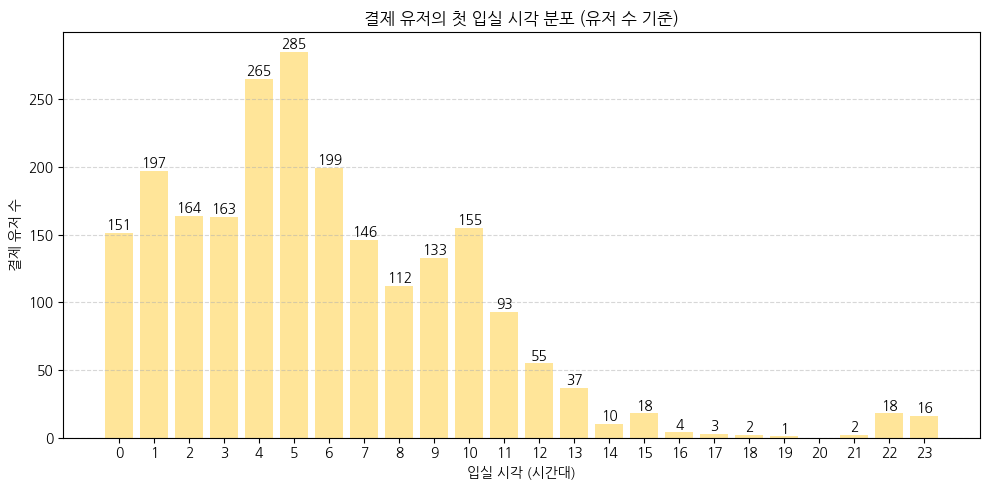

In [ ]:
import matplotlib.pyplot as plt

# 1. 유료 결제자 + 입실 로그만 필터링
paid_checkin_df = access_log_final_df[
    (access_log_final_df['is_payment'] == 1) &
    (access_log_final_df['checkin'] == 1)
].copy()

# 2. 유저별 첫 입실 로그만 추출
first_checkin_df = paid_checkin_df.sort_values('cdate').drop_duplicates('user_uuid', keep='first')

# 3. 입실 시각별 결제 유저 수 집계
user_counts_by_hour = first_checkin_df['hour'].value_counts().sort_index()

# 4. 시각화
plt.figure(figsize=(10, 5))
bars = plt.bar(user_counts_by_hour.index, user_counts_by_hour.values, color='#ffe599')  # 파스텔 노랑

# 5. 막대 위 텍스트 표시
for bar in bars:
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    plt.text(x, y + 0.5, f'{int(y)}', ha='center', va='bottom', fontsize=10)

plt.title('결제 유저의 첫 입실 시각 분포 (유저 수 기준)')
plt.xlabel('입실 시각 (시간대)')
plt.ylabel('결제 유저 수')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# 2. 퇴실 로그만 추출
checkout_df = access_log_final_df[access_log_final_df['checkin'] == 2].copy()

# 3. 유저 + 날짜별 퇴실 시각(hour) 중 가장 빠른 값 선택 (또는 마지막 값 선택도 가능)
checkout_hour_df = checkout_df.groupby(['user_uuid', 'date'])['hour'].max().reset_index()
checkout_hour_df = checkout_hour_df.rename(columns={'hour': 'checkout_hour'})

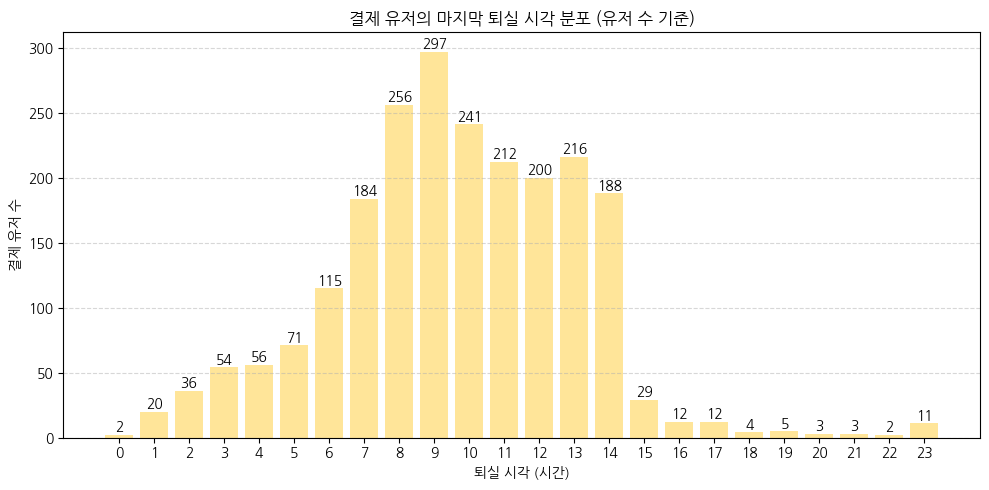

In [ ]:
import matplotlib.pyplot as plt

# 1. 결제 유저 + 퇴실 시각 있는 행만 필터링
checkout_data = access_log_final_df[
    (access_log_final_df['is_payment'] == 1) &
    (access_log_final_df['checkout_hour'].notna())
].copy()

# 2. 퇴실 시각을 정수로 변환
checkout_data['checkout_hour'] = checkout_data['checkout_hour'].astype(int)

# 3. 유저별로 가장 마지막 퇴실 시각 1개만 추출
last_checkout = checkout_data.sort_values('cdate').drop_duplicates('user_uuid', keep='last')

# 4. 퇴실 시각별 결제 유저 수 집계
checkout_user_counts = last_checkout['checkout_hour'].value_counts().sort_index()

# 5. 시각화
plt.figure(figsize=(10, 5))
bars = plt.bar(checkout_user_counts.index, checkout_user_counts.values, color='#ffe599')

# 6. 막대 위에 텍스트 표시
for bar in bars:
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    plt.text(x, y + 0.5, f'{int(y)}', ha='center', va='bottom', fontsize=10)

plt.title('결제 유저의 마지막 퇴실 시각 분포 (유저 수 기준)')
plt.xlabel('퇴실 시각 (시간)')
plt.ylabel('결제 유저 수')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()